In [179]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as npr

from model import make_model, sample_model, plot_forestplots

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation Data

In systematically measuring genotype-phenotype data, how will the data be collected, stored and analyzed? Is a small laptop enough to model the fold change calculations locally? I explore this in the following notebook.

In [180]:
def make_simulated_data(n_reps_low, n_reps_high, n_genotypes):
    means = npr.randint(low=10, high=100, size=n_genotypes)
    means = means * (means > 0)  # negative activities are not captured
    sds = npr.random(size=n_genotypes) * 10
    num_measurements = npr.randint(low=n_reps_low, high=n_reps_high, size=n_genotypes)

    # Create simulated data.
    data = []
    indices = []

    for i in range(n_genotypes):
        n = num_measurements[i]
        mean = means[i]
        sd = sds[i]

        measurements = npr.normal(loc=mean, scale=sd, size=n)
        # print(measurements)
        measurements = measurements * (measurements > 0)
        # print(measurements)

        data.extend(measurements.tolist())
        indices.extend([i] * n)

    # Add baseline measurements (bl_measures)
    n_bl_measures = n_reps_high - 1
    bl_measures = npr.normal(loc=1.0, scale=0.1, size=n_bl_measures)
    bl_measures = bl_measures * (bl_measures > 0)
    data.extend(bl_measures)
    indices.extend([n_genotypes] * n_bl_measures)
    num_measurements = np.append(num_measurements, n_bl_measures)
    means = np.append(means, bl_measures.mean())
    sds = np.append(sds, bl_measures.std())

    # Add pos_ctrl measurements (pc_measures)
    n_pc_measures = n_reps_high - 1
    pc_measures = npr.normal(loc=20.0, scale=1, size=n_pc_measures)
    pc_measures = pc_measures * (pc_measures > 0)
    data.extend(pc_measures)
    indices.extend([n_genotypes + 1] * n_pc_measures)
    num_measurements = np.append(num_measurements, n_pc_measures)
    means = np.append(means, pc_measures.mean())
    sds = np.append(sds, pc_measures.std())

    # convert indices to a numpy array
    indices = np.array(indices)

    return data, indices, num_measurements, means, sds,

In [181]:
# Set n_genotypes > 1000 to obtain estimates of variance in error as a function of num_measurements
# Set n_genotypes < 15 to obtain diagnostic plots (traceplot) and comparison of modelled to actual.
# You've been forewarned - for the diagnostics and modelled, plotting with > 100 takes a while...
n_genotypes = 5000
n_reps_low = 2
n_reps_high = 11

sim_data = make_simulated_data(n_genotypes=n_genotypes, n_reps_low=n_reps_low, n_reps_high=n_reps_high)
data, indices, num_measurements, means, sds = sim_data

In [182]:
# Compute the "actual" Z'-factor for the assay.
zp_det = 1 - (3 * sds[-2] + 3 * sds[-1]) / np.abs(means[-2] - means[-1])
zp_det

0.88014774506883442

In [183]:
model = make_model(n_genotypes, data, indices)

Applied log-transform to upper and added transformed upper_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [184]:
%%time
trace = sample_model(model, n_genotypes)

Iteration 0 [0%]: ELBO = -185166561.25
Iteration 30000 [10%]: Average ELBO = -14241538.92
Iteration 60000 [20%]: Average ELBO = -109022.01
Iteration 90000 [30%]: Average ELBO = -105705.16
Iteration 120000 [40%]: Average ELBO = -105039.61
Iteration 150000 [50%]: Average ELBO = -104903.24
Iteration 180000 [60%]: Average ELBO = -104876.85
Iteration 210000 [70%]: Average ELBO = -104868.52
Iteration 240000 [80%]: Average ELBO = -104865.55
Iteration 270000 [90%]: Average ELBO = -104862.61
Finished [100%]: Average ELBO = -104862.55
CPU times: user 17min 26s, sys: 9.36 s, total: 17min 36s
Wall time: 43min 1s


In [185]:
if n_genotypes <= 15:
    plot_forestplots(trace)

In [186]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['z_factor', 'zp_factor'], vline=0.5)
    plt.xlim(-1, 1)
    plt.savefig('../figures/z-factor_sim.pdf', bbox_inches='tight')

In [187]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['fold'])
    plt.savefig('../figures/foldchange.pdf', bbox_inches='tight')

In [188]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['sigma'])
    plt.savefig('../figures/sigma.pdf', bbox_inches='tight')

In [189]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['fold_changes'])
    plt.savefig('../figures/fold_changes.pdf', bbox_inches='tight')

In [190]:
if n_genotypes <= 15:
    pm.summary(trace)

In [191]:
if n_genotypes <= 15:
    pm.traceplot(trace)

# Error in Estimated Mean

What is the error in estimated mean as a function of the number of measurements?

In [192]:
num_measurements

array([ 6,  6,  9, ...,  9, 10, 10])

In [193]:
trace['fold'].mean(axis=0) - means

array([ 1.59722785, -0.47137648, -0.59695812, ..., -1.35900504,
       -0.00202013,  0.00186922])

In [194]:
import pandas as pd
errors_df = pd.DataFrame([num_measurements, (trace['fold'].mean(axis=0) - means)]).T
errors_df.columns = ['num_measurements', 'error_means']
errors_df.head()

,num_measurements,error_means
0,6.0,1.597228
1,6.0,-0.471376
2,9.0,-0.596958
3,7.0,3.186098
4,10.0,2.688218


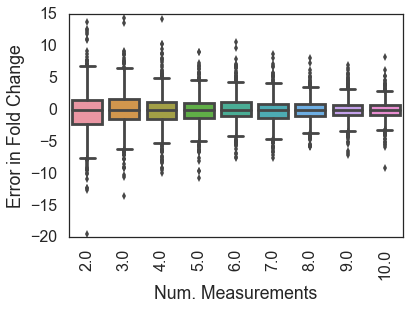

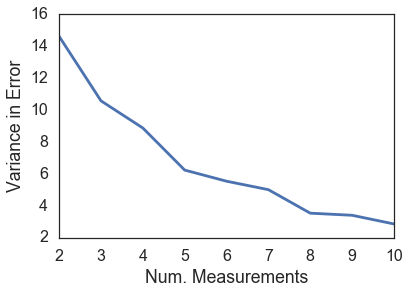

In [195]:
if n_genotypes >= 500 and n_reps_high - n_reps_low > 1:
    sns.boxplot(data=errors_df, x='num_measurements', y='error_means')
    ax = plt.gca()
    labels = ax.get_xticklabels()
    # plt.xticks(x=sorted(list(set(errors_df['num_measurements']))), )
    plt.xticks(rotation=90)
    plt.ylabel('Error in Fold Change')
    plt.xlabel('Num. Measurements')
    plt.savefig('../figures/error-means.pdf', bbox_inches='tight')
    
    errors_df.groupby('num_measurements').var().plot(legend=False)
    plt.ylabel('Variance in Error')
    plt.xlabel('Num. Measurements')
    plt.savefig('../figures/var-error-means.pdf', bbox_inches='tight')

In [196]:
(trace['fold'].mean(axis=0) - means).mean()

-0.013793103894467244

In [197]:
if n_genotypes <= 15:
    plt.figure()
    pm.traceplot(trace, varnames=['fold'])
    plt.figure()

# Compare modelled to actual

In [198]:
trace['fold'].mean(axis=0)

array([ 89.59722785,  41.52862352,  43.40304188, ...,  84.64099496,
         1.00304868,  19.5951909 ])

In [199]:
trace['fold'].mean(axis=0).shape

(5002,)

In [200]:
np.arange(1, n_genotypes+3).shape

(5002,)

In [201]:
if n_genotypes <= 15:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lower = trace['fold'].mean(axis=0) - np.percentile(trace['fold'], 2.5, axis=0)
    upper = np.percentile(trace['fold'], 97.5, axis=0) - trace['fold'].mean(axis=0)
    yerr_pos = [lower, upper]
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=trace['fold'].mean(axis=0), 
                # y-error bars
                yerr=yerr_pos,
                # styling
                color='blue', ls='none', alpha=0.5, label='modeled',)
    ax.scatter(x=np.arange(1, n_genotypes+3), y=means, 
               # styling
               color=['red'] * (n_genotypes) + ['green'] + ['blue'], marker='o', s=100, label='true mean',)
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=means,
               yerr=sds,
               color='red', ls='none', alpha=0.5, label='true var')
    ax.legend(loc='upper left', frameon=False)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-2], linestyles='--', alpha=0.2)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-1], alpha=0.2)
    ax.set_xlabel('genotype ID')
    ax.set_ylabel('fold change')
    # ax.set_xlim(, n_genotypes+2)

In [202]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
print('just for checking the above plot...')

just for checking the above plot...


## How often is the true mean inside the 95% HPD?

In [203]:
lower, upper = np.percentile(trace['fold'], [2.5, 97.5], axis=0)
lower, upper

(array([ 87.88246089,  40.70223662,  40.52146279, ...,  79.94414251,
          0.94446877,  19.10401627]),
 array([ 91.05025255,  42.36330143,  46.36997249, ...,  88.43486694,
          1.06543799,  20.09424461]))

In [204]:
means

array([ 88.        ,  42.        ,  44.        , ...,  86.        ,
         1.00506881,  19.59332167])

In [205]:
# Here is the fraction of means that have been correctly included within the 95% HPD.
sum((means > lower) *  (means < upper)) / len(means)

0.88564574170331867

## What is the distribution of SEM vs. 95% CI vs. Bayesian 95% HPD?

In [206]:
if n_genotypes >= 500 and n_reps_high - n_reps_low == 1:
    df = pd.DataFrame()
    df['measurements'] = data
    df['indices'] = indices
    df.groupby('indices').std()

    errorbars = pd.DataFrame()
    errorbars['SEM'] = 2 * df.groupby('indices').std()['measurements'] / np.sqrt(num_measurements)
    errorbars['Frequentist'] = 1.96 * errorbars['SEM']
    errorbars['Bayesian'] = upper - lower
    errorbars['Data'] = df.groupby('indices')['measurements'].max() - df.groupby('indices')['measurements'].min()
    # errorbars['Data'] = df.groupby('indices')['measurements'].var

    alpha = 0.4
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    # ax.set_aspect('equal')
    ax.scatter(x=errorbars['Data'], y=errorbars['Frequentist'], color='red', label='Frequentist 95% CI', alpha=alpha)
    ax.scatter(x=errorbars['Data'], y=errorbars['Bayesian'], color='blue', label='Bayesian 95% CI', alpha=alpha)
    ax.scatter(x=errorbars['Data'], y=errorbars['SEM'], color='green', label='Std. Err. Mean', alpha=alpha)

    lims = [
        0,  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]) - 10,  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.legend(loc='upper left')
    ax.set_ylabel('Interval Width')
    ax.set_xlabel('Data Range (Max - Min)')
    plt.savefig('../figures/simulation-range-estimates.pdf', bbox_inches='tight')